# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Egl-9-is-epistatic-to-vhl-1" data-toc-modified-id="Egl-9-is-epistatic-to-vhl-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Egl-9 is epistatic to vhl-1</a></div><div class="lev1 toc-item"><a href="#hif-1-suppresses-egl-9" data-toc-modified-id="hif-1-suppresses-egl-9-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>hif-1 suppresses egl-9</a></div><div class="lev1 toc-item"><a href="#Transitivity-holds-in-transcriptomes:" data-toc-modified-id="Transitivity-holds-in-transcriptomes:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Transitivity holds in transcriptomes:</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np
from IPython.core.display import HTML

# stats
from scipy import stats as sts
import statsmodels.api as stm

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


from IPython.core.display import HTML

# bokeh
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

from scipy.stats import gaussian_kde

bokeh.io.output_notebook()


ft = 35 #title fontsize

Loading BokehJS ...

In [2]:
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14
lgnd_title_size = 15

In [3]:
import scipy.odr as odr

In [4]:
import genpy
import gvars
import morgan

In [5]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [6]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [7]:
genvar = gvars.genvars()

In [8]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]

tidy_data = pd.concat(frames)

In [63]:
def label(code1, code2):
    """A function to make epistasis labels given two code-letters"""
    return '{0} $>$ {1}'.format(genvar.fancy_mapping[code1],
                                genvar.fancy_mapping[code2])


def find_overlap(genotypes, df, q=0.1):
    """
    Given a list of genotypes, a tidy df and a q-value, find the genes that are D.E in all.
    """
    sig = df[(df.code.isin(genotypes)) & (df.qval < q)]
    grouped = sig.groupby('target_id')
    
    genes = []
    for target, group in grouped:
        if (group.qval < q).all() & (len(group.code.unique()) == len(genotypes)):
            genes += [target]
    
    return genes


def find_additive(single_muts, double_mut, df, q=0.1):
    """
    Given single double mutant, find the DE genes common to all and return sliced dataframes.
    """
    if type(single_muts) is not list:
        raise ValueError('single_muts must be of type list')
    if type(double_mut) is not str:
        raise ValueError('double_mut must be of type str')

    # find the overlapping gene list
    genes = find_overlap(single_muts + [double_mut], df)

    # extract the dataframes
    x = tidy_data[(tidy_data.target_id.isin(genes)) & (tidy_data.code == single_muts[0])]
    y = tidy_data[(tidy_data.target_id.isin(genes)) & (tidy_data.code == single_muts[1])]
    xy = tidy_data[(tidy_data.target_id.isin(genes)) & (tidy_data.code == double_mut)]

    # return the dataframes
    return x, y, xy


def f(B, x):
    """A linear function for the ODR."""
    return B*(x)

def perform_odr(add, dev, wadd, wdev):
    """A wrapper to calculate an ODR regression."""
    linear = odr.Model(f)
    mydata = odr.Data(add, dev, wd=1./wadd, we=1./wdev)
    myodr = odr.ODR(mydata, linear, beta0=[0])
    myoutput = myodr.run()
    return myoutput

def weighted_regression_delta(singles, double, epistasis):
    """
    find the WLS regression in an epistasis plot between single muts and a double mut.
    """
    if len(singles) != 2:
        raise ValueError('`singles` must be a list with two dataframes!')
    
    X = singles[0].b + singles[1].b

    # fit an ODR model
    wadd = np.sqrt(singles[1].se_b**2 + singles[0].se_b**2)

    if epistasis == -1:
        wdev = double.se_b**2
        for i, df in enumerate(singles):
            wdev += df.se_b**2
        wdev = np.sqrt(wdev)

        output = perform_odr(X, double.b - X, wadd=wadd, wdev=wdev)

    if epistasis == 0:
        # if XY = X, then XY - X - Y = -Y
        output = perform_odr(X, -singles[1].b, wadd=wadd, wdev=singles[1].se_b)

    if epistasis == 1:        
        # if XY = Y, then XY - X - Y = -X
        output = perform_odr(X, -singles[0].b, wadd=wadd, wdev=singles[0].se_b)

    return output


def plot_epistasis_regression(X, slope, **kwargs):
    """Plot the WLS line."""
    # find the xmin and xmax:
    xmin = X.min()
    xmax = X.max()

    # make a linear array for x
    x = np.linspace(xmin - 0.1, xmax + 0.1, 1000)

    # make the models
    y0 = x*slope

    # plot the models
    plt.plot(x, y0, **kwargs)

    
def bootstrap(bframe, sebframe, epistasis='actual', nsim=1000):
    
    nsim = int(nsim)
    # unpack
    xb, yb, xyb = bframe
    xseb, yseb, xyseb = sebframe
    
    beta = np.zeros(nsim)
    se_beta = np.zeros(nsim)
    for i in range(nsim):
        # test the construction.
        indices = np.random.randint(0, len(xb), len(xb))

        # extract the array stuff:
        currx = xb[indices]
        curry = yb[indices]
        currxy = xyb[indices]

        currsex = xseb[indices]
        currsey = yseb[indices]
        currsexy = xyseb[indices]
    
        # different bootstraps to do:
        if epistasis == 'actual':
            X = currx + curry
            Y = currxy - X
            wadd = np.sqrt(currsex**2 + currsey**2)
            wdev = wadd**2 + currsexy**2
            
        elif epistasis == 'XY=X':
            X = currx + curry
            Y = -curry
            wadd = np.sqrt(currsex**2 + currsey**2)
            wdev = currsey
            
        elif epistasis == 'XY=Y':
            X = currx + curry
            Y = -currx
            wadd = np.sqrt(currsex**2 + currsey**2)
            wdev = currsex

        elif epistasis == 'XY=X+Y':
            X = currx + curry
            Y = 0
            wadd = np.sqrt(currsex**2 + currsey**2)
            wdev = currsex

        elif epistasis == 'XY=X=Y':
            # flip a coin:
            coin = np.random.randint(0, 1)
            
            # half the time use the X data
            # half the time use the Y
            if coin == 0:
                X = 2*currx
                Y = -currx
                wadd = np.sqrt(2*currsex**2)
                wdev = currsex
            
            else:
                X = 2*curry
                Y = -curry
                wadd = np.sqrt(2*currsey**2)
                wdev = currsex
        
        elif epistasis == 'suppress':
            # flip a coin:
            coin = np.random.randint(0, 1)
            
            # half the time use the X data
            # half the time use the Y
            if coin == 0:
                X = curry
                Y = -curry
                wadd = currsey
                wdev = currsex
            
            else:
                X = currx
                Y = -currx
                wadd = currsex
                wdev = currsey

        # turn X, Y into random vars:
        X = np.random.normal(X, wadd)
        Y = np.random.normal(Y, wdev)
        
        # do calcs and store in vectors
        output = perform_odr(X, Y, wadd=wadd, wdev=wdev)
        beta[i] = output.beta[0]
        se_beta[i] = output.sd_beta[0]
    
    return beta, se_beta


def bootstrap_regression(singles, double, df, epistasis='actual', nsim=100):
    """
    """    
    nsim = int(nsim)
    x, y, xy = find_additive(singles, double, df)
        
    xb = x.b.values
    yb = y.b.values
    xyb = xy.b.values

    xseb = x.se_b.values
    yseb = y.se_b.values
    xyseb = xy.se_b.values

    beta, sebeta = bootstrap([xb, yb, xyb],
                             [xseb, yseb, xyseb],
                             epistasis=epistasis,
                             nsim=nsim)
    return beta, sebeta
        

def epistasis_plot(singles, double, df, **kwargs):
    """
    """

    x, y, xy = find_additive(singles, double, df)
    actual = weighted_regression_delta([x,y], xy, -1)
    x_over_y = weighted_regression_delta([x,y], xy, 0)
    y_over_x = weighted_regression_delta([x,y], xy, 1)

    X = x.b + y.b
    Y = xy.b - X

    # Calculate the point density
    points = np.vstack([X,Y])
    z = gaussian_kde(points)(points)

    fig, ax = plt.subplots()
    if len(X) > 50:
        ax.scatter(X, Y, c=z, s=15/np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2),
                    edgecolor='', cmap='viridis', alpha=0.5)
    else:
        ax.scatter(X, Y, c=z, s=15/np.sqrt(x.se_b**2 + y.se_b**2 + xy.se_b**2),
                   edgecolor='', cmap='viridis', alpha=1)

    

    plt.plot(X, -1/2*X, 'k--', label='Unbranched Pathway')
    x_y_lab = label(singles[0], singles[1])
    y_x_lab = label(singles[1], singles[0])
    plot_epistasis_regression(X, actual.beta, ls='-', lw=2, color='#984ea3', label='fit')

    plt.xlabel(r'Predicted Additive Effect')
    plt.ylabel(r'Deviation from Additive Effect')
    
    plt.legend()
    
    return x, y, xy, x_over_y, y_over_x, actual


def curves(means, errors, labels, **kwargs):
    """
    """
    def normal(x, mu, sigma):
        return 1/(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2))
    
    maxe = np.max(errors)
    maxm = np.max(means)
    minm = np.min(means)
    
    color = kwargs.pop('color', {})
    fill = kwargs.pop('fill', False)

    X = np.linspace(minm - 3*maxe, maxm+3*maxe, 1000)
    
    fig, ax = plt.subplots()
    for i, mean in enumerate(means):
        if labels[i] is 'fit':
            lw = 3
        else:
            lw = 2
        
        if len(color) > 0:
            plot = plt.plot(X, normal(X, mean, errors[i]),
                        label=labels[i], lw=lw, color=color[labels[i]])
        else:
            plot = plt.plot(X, normal(X, mean, errors[i]),
                        label=labels[i], lw=lw)
        if not fill:
            next

        if labels[i] is 'fit':
            ax.fill_between(X, 0, normal(X, mean, errors[i]), color='r', alpha=0.3)

    
    if minm - 3*maxe < -0.5 < maxm - 3*maxe:
        plt.gca().axvline(-0.5, color='k', ls='--', label='Unbranched Pathway')
    if minm - 3*maxe < 0 < maxm - 3*maxe:
        plt.gca().axvline(0, color='k', ls='-.', label='Additive Model')
    
    plt.legend(loc='upper right')
    plt.title('Epistasis Coefficient Predictions vs. Observed')
    plt.xlabel('Epistasis Coefficient')
    plt.ylabel('Density')

In [64]:
np.zeros(10)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [65]:
hifoh = pd.read_csv('../output/hifoh_candidates.csv')

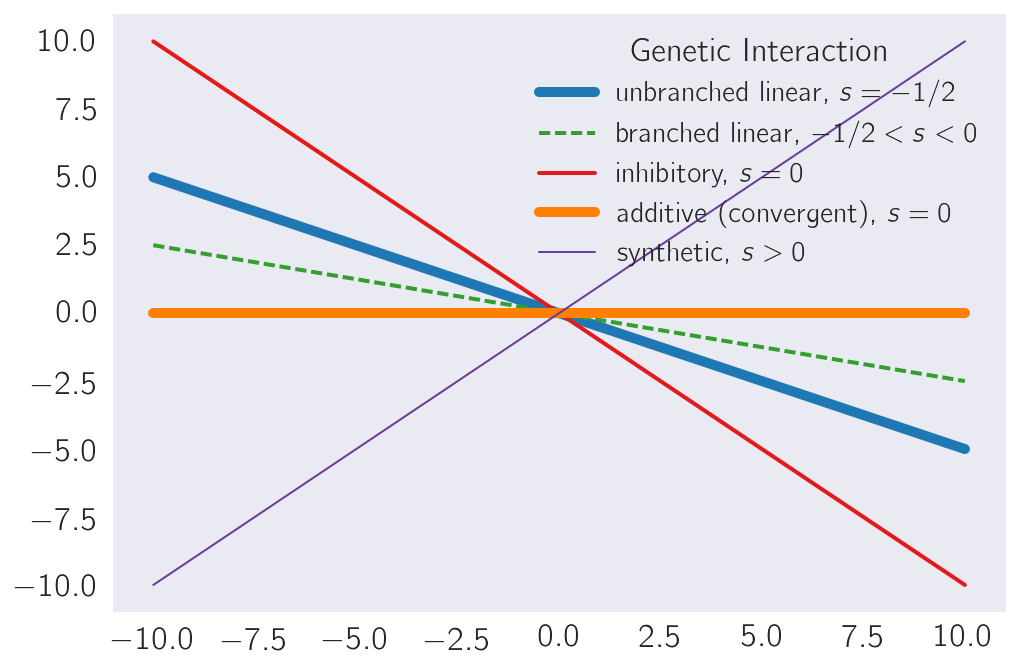

In [66]:
X = np.linspace(-10, 10)
Y = -1/2*X

plt.plot(X, -1/2*X, ls='-', color= '#1f78b4', lw=5, label='unbranched linear, $s=-1/2$')
plt.plot(X, -1/4*X, ls='--', color= '#33a02c', label='branched linear, $-1/2 < s < 0$')
plt.plot(X, -X, ls='-', lw=2, color= '#e31a1c', label='inhibitory, $s = 0$')
plt.plot(X, 0*X, 'k-', lw=5, color= '#ff7f00', label='additive (convergent), $s = 0$')
plt.plot(X, X, '-', lw=1,color= '#6a3d9a',  label='synthetic, $s > 0$')

lgd = plt.legend()
lgd.set_title('Genetic Interaction', prop=(mpl.font_manager.FontProperties(size=16)))
plt.savefig('../output/epistasis_plot_show.svg', bbox_inches='tight')

# Egl-9 is epistatic to vhl-1

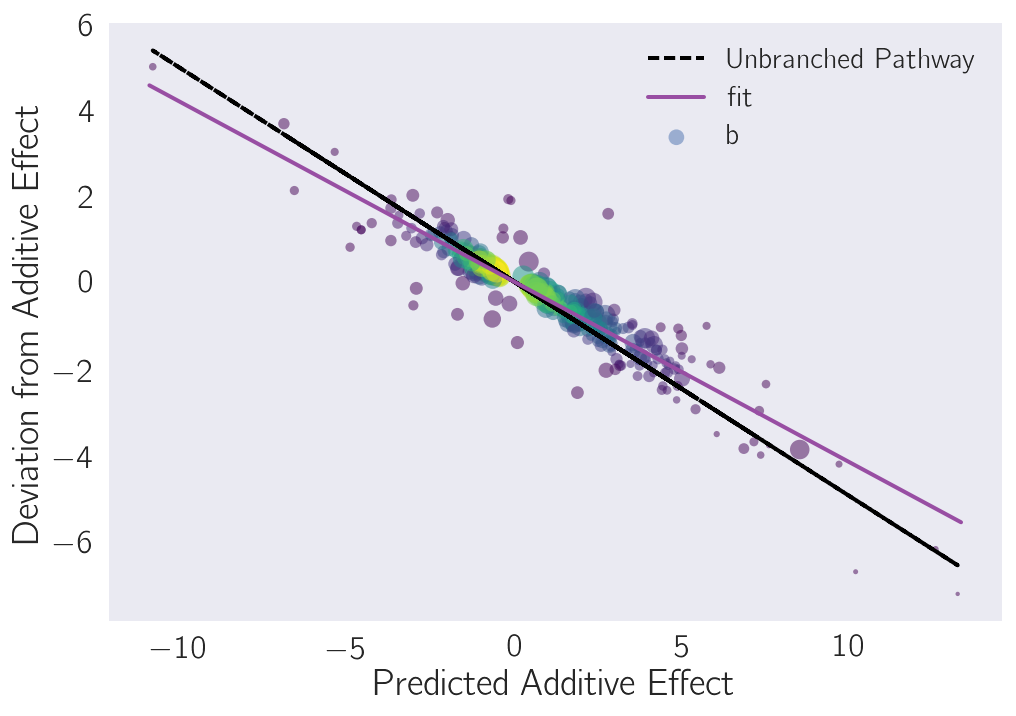

In [106]:
letter1 = 'b'
letter2 = 'd'
double = genvar.double_mapping[letter1 + letter2]
x, y, xy, x_over_y, y_over_x, actual = epistasis_plot([letter1, letter2],
                                                      double, tidy_data)
plt.savefig('../output/epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [110]:
add = x[x.ext_gene == 'ftn-1'].b + y[y.ext_gene == 'ftn-1'].b
dev = xy[xy.ext_gene == 'ftn-1'].b - add

In [80]:
def calculate_all_bootstraps(letter1, letter2, double, tidy_data, nsim=5000):
    
    beta_actual, seb_actual = bootstrap_regression([letter1, letter2], double, tidy_data, epistasis='actual', nsim=1000)
    beta_x, seb_x = bootstrap_regression([letter1, letter2], double, tidy_data, epistasis='XY=X', nsim=1000)
    beta_y, seb_y = bootstrap_regression([letter1, letter2], double, tidy_data, epistasis='XY=Y', nsim=1000)
    beta_single, seb_single = bootstrap_regression([letter1, letter2], double, tidy_data, epistasis='XY=X=Y', nsim=1000)
    beta_add, seb_add = bootstrap_regression([letter1, letter2], double, tidy_data, epistasis='XY=X+Y', nsim=1000)
    beta_sup, seb_sup = bootstrap_regression([letter1, letter2], double, tidy_data, epistasis='suppress', nsim=1000)
        
    betas = {'actual': beta_actual, 'null': beta_add, 'unbranched': beta_single,
             'suppressed': beta_sup, 'xy=x': beta_x, 'xy=y': beta_y
            }

    return betas 

def plot_bootstraps(betas, **kwargs):
    
    sns.kdeplot(data=betas['actual'], label='actual', color='#33a02c', **kwargs)
    sns.kdeplot(data=betas['xy=x'], label=label(letter1, letter2), color='blue', **kwargs)
    sns.kdeplot(data=betas['xy=y'], label=label(letter2, letter1), color='k', **kwargs)
    sns.kdeplot(data=betas['unbranched'], label='Unbranched', color='#1f78b4', **kwargs)
    sns.kdeplot(data=betas['null'], label='Additive', color='#ff7f00', **kwargs)
    sns.kdeplot(data=betas['suppressed'], label='Suppression', color='#e31a1c', **kwargs)
    
    plt.gca().axvline(betas['actual'].mean(), color='#984ea3', ls='--', lw=3)
    
    plt.xlabel('Epistasis Coefficient')
    plt.ylabel('Cumulative Density Function')


In [72]:
betas = calculate_all_bootstraps(letter1, letter2, double, tidy_data)

In [84]:
betas['XY=X'.lower()].mean()

-0.4191620284679976

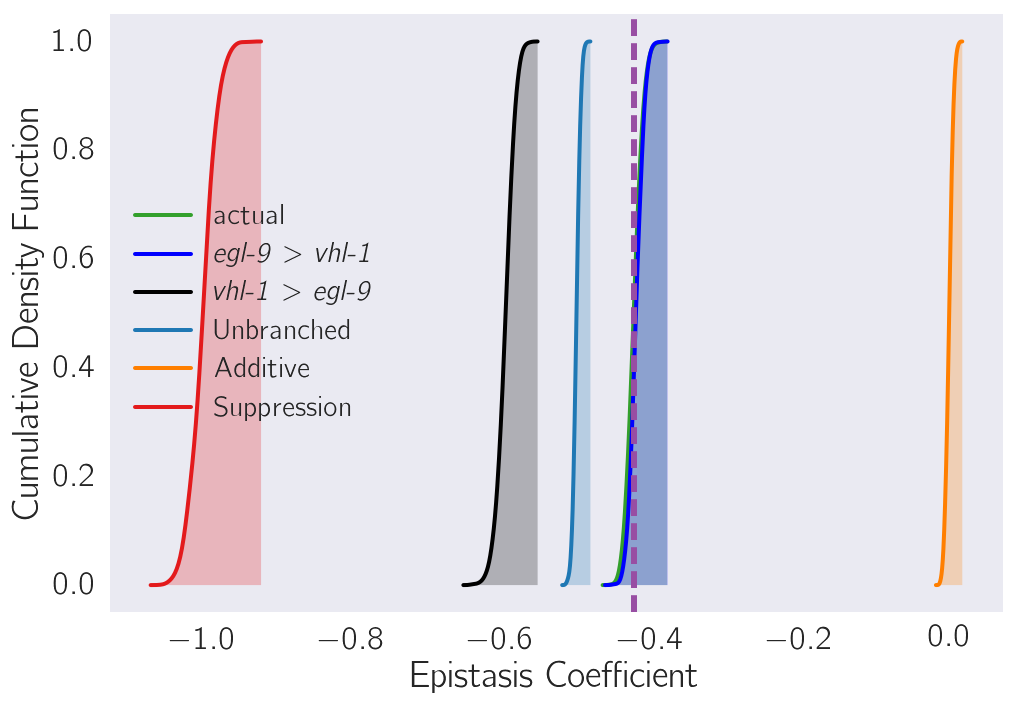

In [81]:
plot_bootstraps(betas, cumulative=True, shade=True)
plt.xlabel('Epistasis Coefficient')
plt.ylabel('Cumulative Density Function')
plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

# hif-1 suppresses egl-9

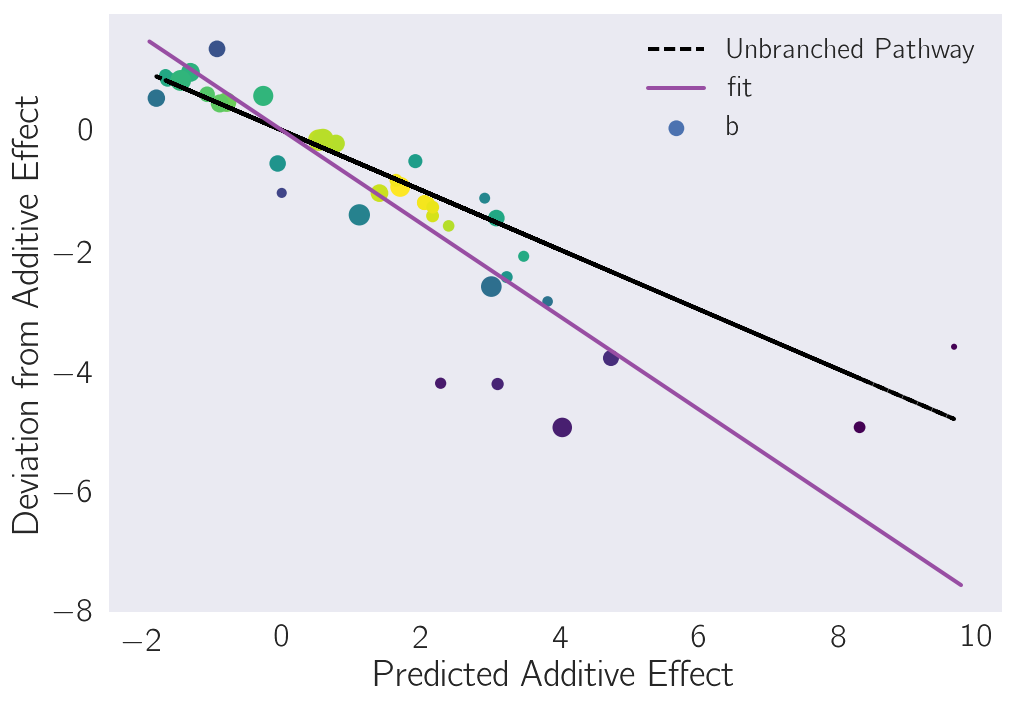

In [99]:
letter1 = 'b'
letter2 = 'c'
double = genvar.double_mapping[letter1 + letter2]
x, y, xy, x_over_y, y_over_x, actual = epistasis_plot([letter1, letter2],
                                                      double, tidy_data)
plt.savefig('../output/epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [101]:
betas = calculate_all_bootstraps(letter1, letter2, double, tidy_data)

In [104]:
betas['XY=Y'.lower()].mean()

-0.71567339790764428

In [102]:
betas['actual'].mean()

-0.84106537147011495

In [105]:
len(betas['xy=y'][betas['xy=y'] < -0.841])/len(betas['xy=y'])

0.061

In [92]:
len(betas['suppressed'][betas['suppressed'] > -1])/len(betas['suppressed'])

0.529

In [95]:
len(betas['unbranched'][betas['unbranched'] < betas['actual'].mean()])/len(betas['unbranched'])

0.0

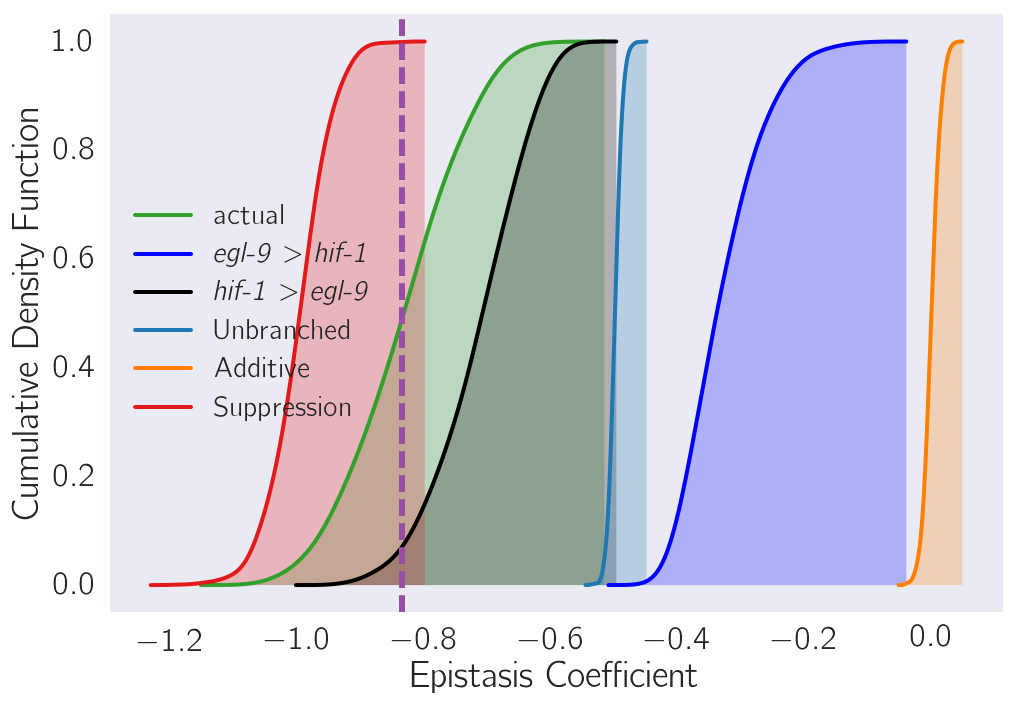

In [93]:
plot_bootstraps(betas, cumulative=True, shade=True)

# Transitivity holds in transcriptomes:

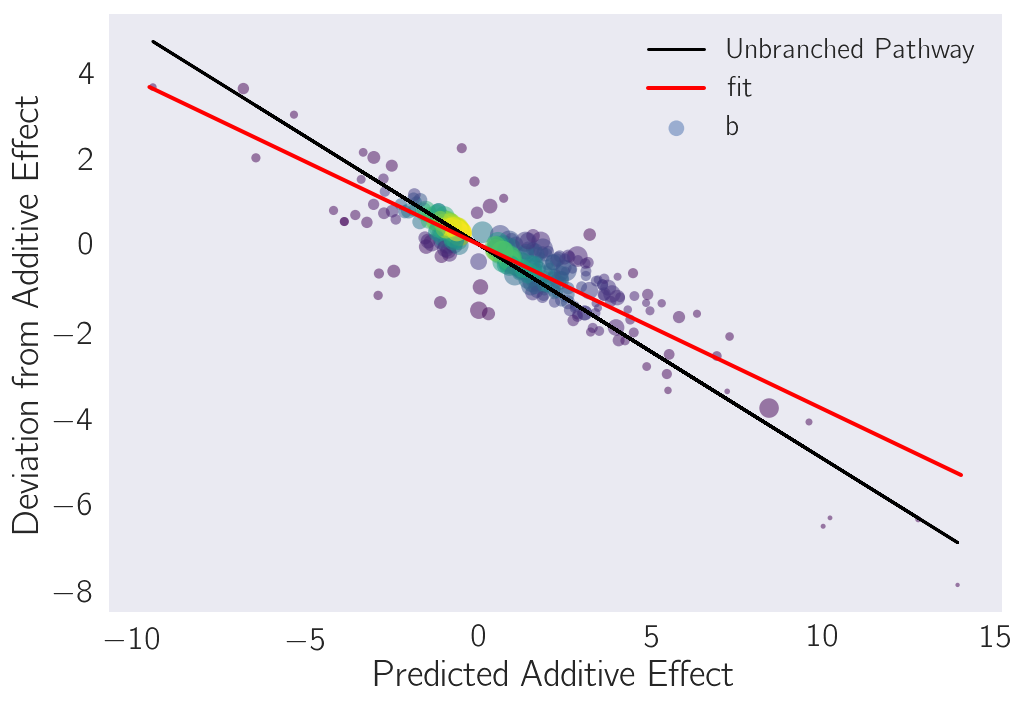

In [41]:
letter1 = 'e'
letter2 = 'd'
double = genvar.double_mapping['b' + letter2]
x, y, xy, x_over_y, y_over_x, actual = epistasis_plot([letter1, letter2],
                                                      double, tidy_data)

In [ ]:
curves([x_over_y.beta[1], y_over_x.beta[1], actual.beta[1]],
       [x_over_y.sd_beta[1], y_over_x.sd_beta[1], actual.sd_beta[1]],
       labels=[label(letter1, letter2), label(letter2, letter1), 'fit'])

plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')

In [42]:
betas = calculate_all_bootstraps(letter1, letter2, double, tidy_data)

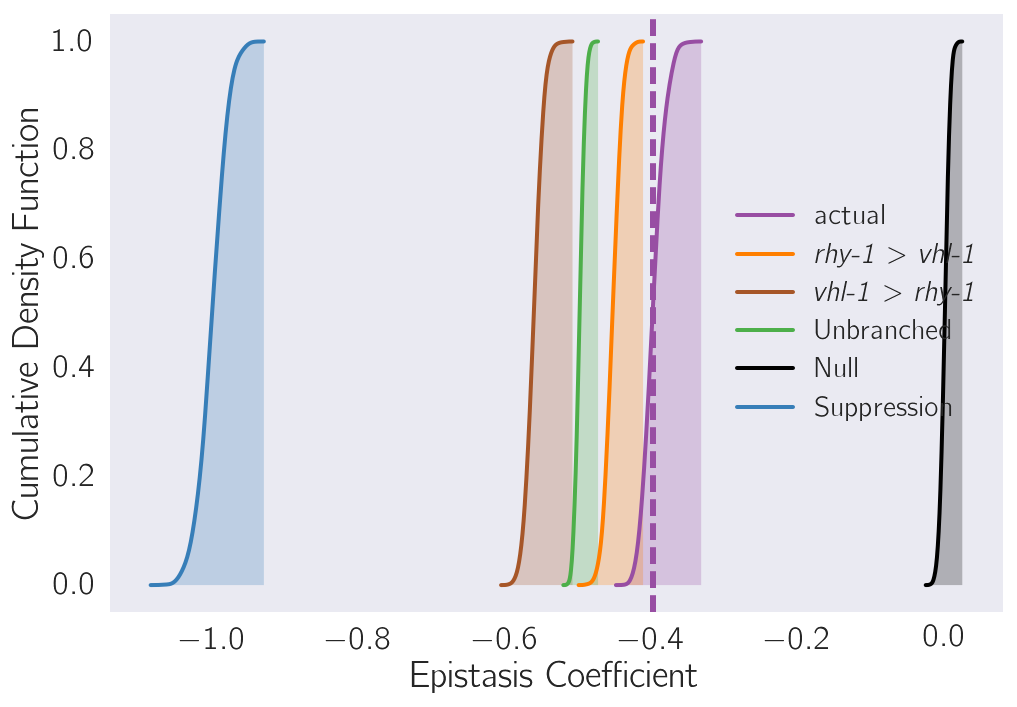

In [43]:
plot_bootstraps(betas, cumulative=True, shade=True)

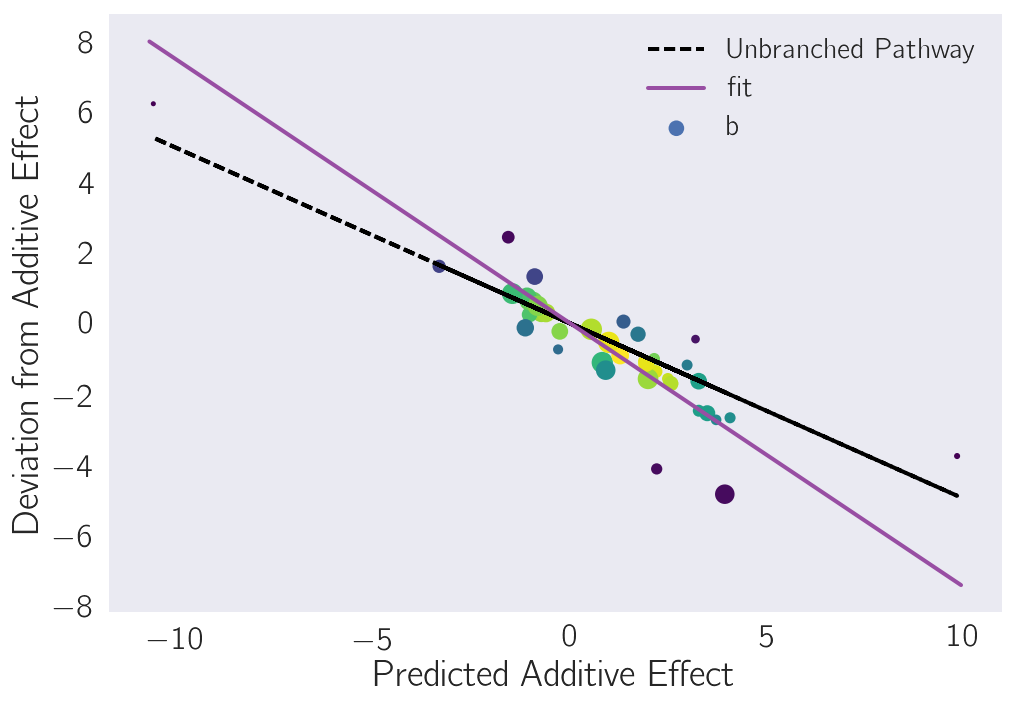

In [96]:
letter1 = 'e'
letter2 = 'c'
double = genvar.double_mapping['b' + letter2]
x, y, xy, x_over_y, y_over_x, actual = epistasis_plot([letter1, letter2],
                                                      double, tidy_data)

In [97]:
betas = calculate_all_bootstraps(letter1, letter2, double, tidy_data)

pval=0


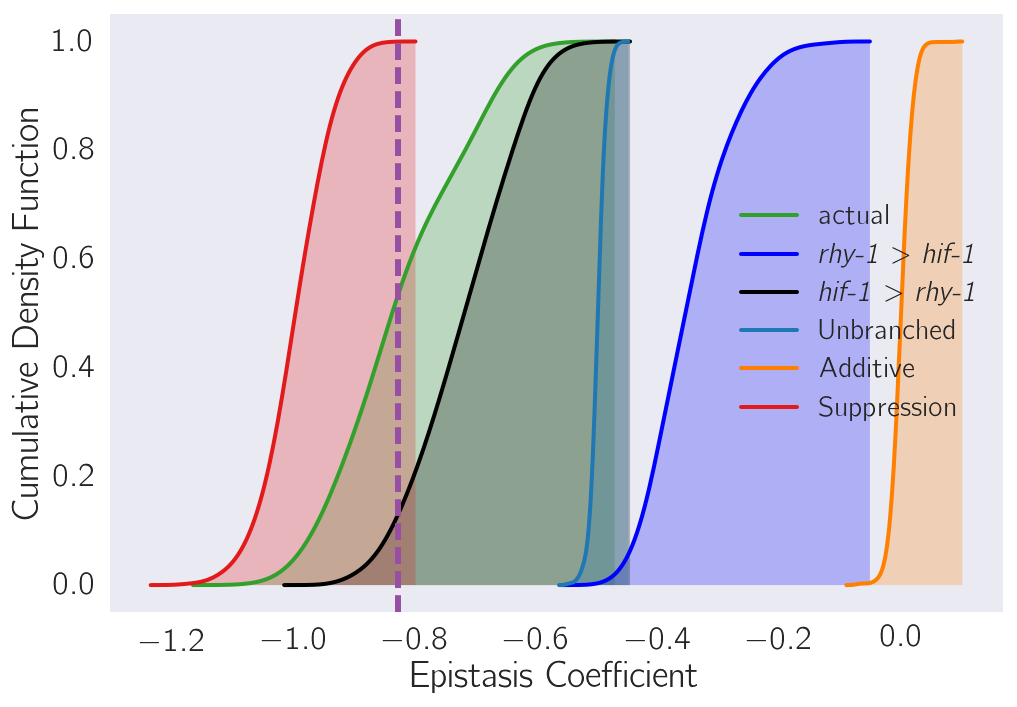

In [98]:
print('pval={0:.2g}'.format(len(betas['unbranched'][betas['unbranched'] < betas['actual'].mean()])/len(betas['unbranched'])))
plot_bootstraps(betas, cumulative=True, shade=True)

In [ ]:
curves([x_over_y.beta[1], y_over_x.beta[1], actual.beta[1]],
       [x_over_y.sd_beta[1], y_over_x.sd_beta[1], actual.sd_beta[1]],
       labels=[label(letter1, letter2), label(letter2, letter1), 'fit'])

plt.savefig('../output/kde-epistasis{0}{1}.svg'.format(genvar.mapping[letter1], genvar.mapping[letter2]),
            bbox_inches='tight')